<a href="https://colab.research.google.com/github/ngcheeyuan/Fraud_Detection_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [76]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#outlier detection
from sklearn.svm import OneClassSVM

In [77]:
df_0 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/young_adults_female_urban.csv', sep ='|')
df_1 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/young_adults_male_urban.csv', sep ='|')
df_2 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_2550_male_urban.csv', sep ='|')
df_3 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_2550_female_urban.csv', sep ='|')
df_4 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_50up_male_urban.csv', sep ='|')
df_5 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_50up_female_urban.csv', sep ='|')

In [78]:
df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5])

In [79]:
df['trans_date_time'] = df['trans_date'] + " " + df['trans_time']
df.loc[:,'trans_date_time'] = pd.to_datetime(df['trans_date_time'])

In [80]:
#df['trans_date_time'].dtype

In [81]:
df.loc[:,'dob'] = pd.to_datetime(df['dob'],format= '%Y-%m-%d')

In [82]:
df.sort_values(by = 'trans_date_time', ascending = True , inplace = True)
df.set_index('trans_date_time', inplace = True)

In [83]:
#creating basic date related features
df['trans_year'] = df.index.year
df['trans_month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df.loc[:,'weekday'] =  df['weekday'] + 1
df['day'] = df.index.day

In [84]:
check_dup = df.groupby('cc_num').agg({'first':np.count_nonzero,'acct_num':np.count_nonzero})
check_dup['check'] =check_dup['first'] - check_dup['acct_num']
check_dup['check'].value_counts() # no duplicated accounts.

0    514
Name: check, dtype: int64

In [85]:
df.loc[df['trans_num'].duplicated()] # no duplicated transactions

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_month,weekday,hour,day
trans_date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [86]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['dob'] = pd.to_datetime(df['dob'])
df['age_at_trans'] = df['trans_date'] - df['dob']
df.loc[:,'age_at_trans']=df['age_at_trans'].map(lambda x : x.days)
df.loc[:,'age_at_trans'] = np.round(df['age_at_trans']/365.25)

In [87]:
df.loc[df['age_at_trans']<18]
#card holders are all above 18, at time of transaction.

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_month,weekday,hour,day,age_at_trans
trans_date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [88]:
df.loc[:,'merchant'] = df['merchant'].map(lambda x : x.replace('fraud_',''))

In [89]:
df['name'] = df['first'] + ' ' + df['last']

In [90]:
df['cc_num'].unique().shape,df['acct_num'].unique().shape,df['ssn'].unique().shape #seems like these are all unique idenitfiers for the different credit cards

((514,), (514,), (514,))

In [91]:
df.drop(columns = ['profile'] , inplace = True)

## Train test split prior to EDA

In [92]:
df.loc['2012-01-01':'2014-12-31'].to_csv('train_ts.csv')
df.loc['2015-01-01':'2015-12-31'].to_csv('test_ts.csv')

In [93]:
#from google.colab import files
#files.download("train_ts.csv")
#files.download("test_ts.csv")

## EDA

In [94]:
df = pd.read_csv('train_ts.csv')

In [95]:
df.loc[:,'trans_date_time'] = pd.to_datetime(df['trans_date_time'])
df.set_index('trans_date_time', inplace = True)

In [96]:
mask = df['is_fraud'] == 1

In [97]:
df['is_fraud'].mean(), 1 - df['is_fraud'].mean()

(0.0027080028171906478, 0.9972919971828094)

We have a severely imbalanced data set on our hands, where only 0.27% of all transactions are fraudulent. 

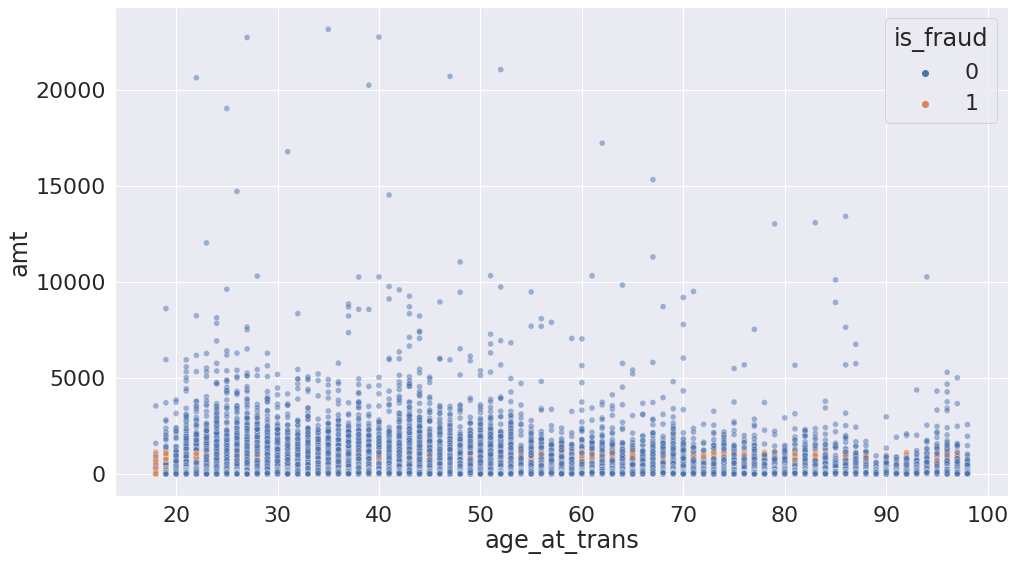

In [98]:
plt.figure(figsize=(16,9))
sns.scatterplot(data = df , x = 'age_at_trans', y = 'amt' , hue = 'is_fraud',alpha = 0.5)

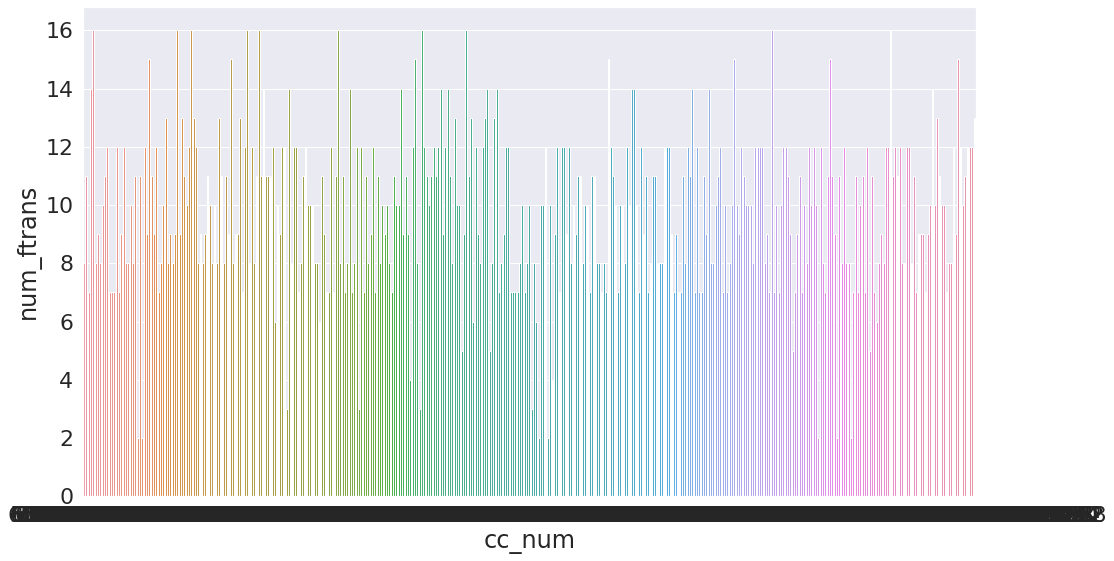

In [99]:
f_exp = df[mask].groupby('cc_num').agg({'is_fraud':np.sum}).rename(columns = {'is_fraud':'num_ftrans'}).reset_index()
plt.figure(figsize = (16,9))
sns.barplot(data = f_exp, x = 'cc_num', y = 'num_ftrans') #

In [100]:
f_exp['num_ftrans'].value_counts()

12    65
8     63
11    53
7     50
10    48
9     40
14    14
13    11
16    10
15     7
2      7
6      5
5      4
3      4
4      2
Name: num_ftrans, dtype: int64

Fraudulent transactions with the same card tends to happen more than once. 

No clear visual difference between fraudulent acitivity and age of card holder when transaction occured.

In [101]:
def age_bin(df_):
  x = df_['age_at_trans']
  condlist = [x<=age for age in np.arange(20,110,10)]
  choicelist = [bin for bin in np.arange(20,110,10)]
  df_['age_bin'] = np.select(condlist,choicelist)

  return df_

In [102]:
df = age_bin(df)

In [103]:
df.groupby('age_bin').agg({'is_fraud':[np.mean,np.std],
                          'amt':[np.min,np.max,np.mean,np.median,np.std,np.count_nonzero]})

is_fraud            amt  ...                                  
             mean       std amin  ...  median         std count_nonzero
age_bin                           ...                                  
20       0.005131  0.071453  1.0  ...  23.005  177.505804       11108.0
30       0.002534  0.050279  1.0  ...  31.940  176.409590      253705.0
40       0.001805  0.042445  1.0  ...  47.010  156.870334      335762.0
50       0.002045  0.045175  1.0  ...  46.160  155.777787      337901.0
60       0.003541  0.059400  1.0  ...  48.010  150.091971      194870.0
70       0.004572  0.067460  1.0  ...  48.980  160.025546      113523.0
80       0.003920  0.062487  1.0  ...  48.730  133.145790       67349.0
90       0.004656  0.068080  1.0  ...  47.975  179.353878       40804.0
100      0.003045  0.055097  1.0  ...  48.845  150.482757       27916.0

[9 rows x 8 columns]

In [104]:
temp_df1 = df['age_bin'].value_counts().reset_index().rename(columns={'index':'age_bin','age_bin':'num_of_trans'})
mask = df['is_fraud']==1
temp_df2 = df[mask]['age_bin'].value_counts().reset_index().rename(columns={'index':'age_bin','age_bin':'num_of_trans'})

In [105]:
age_exp = temp_df1.merge(temp_df2,how = 'left', on = 'age_bin')
age_exp['proportion_fraud'] = age_exp['num_of_trans_y']/age_exp['num_of_trans_x']

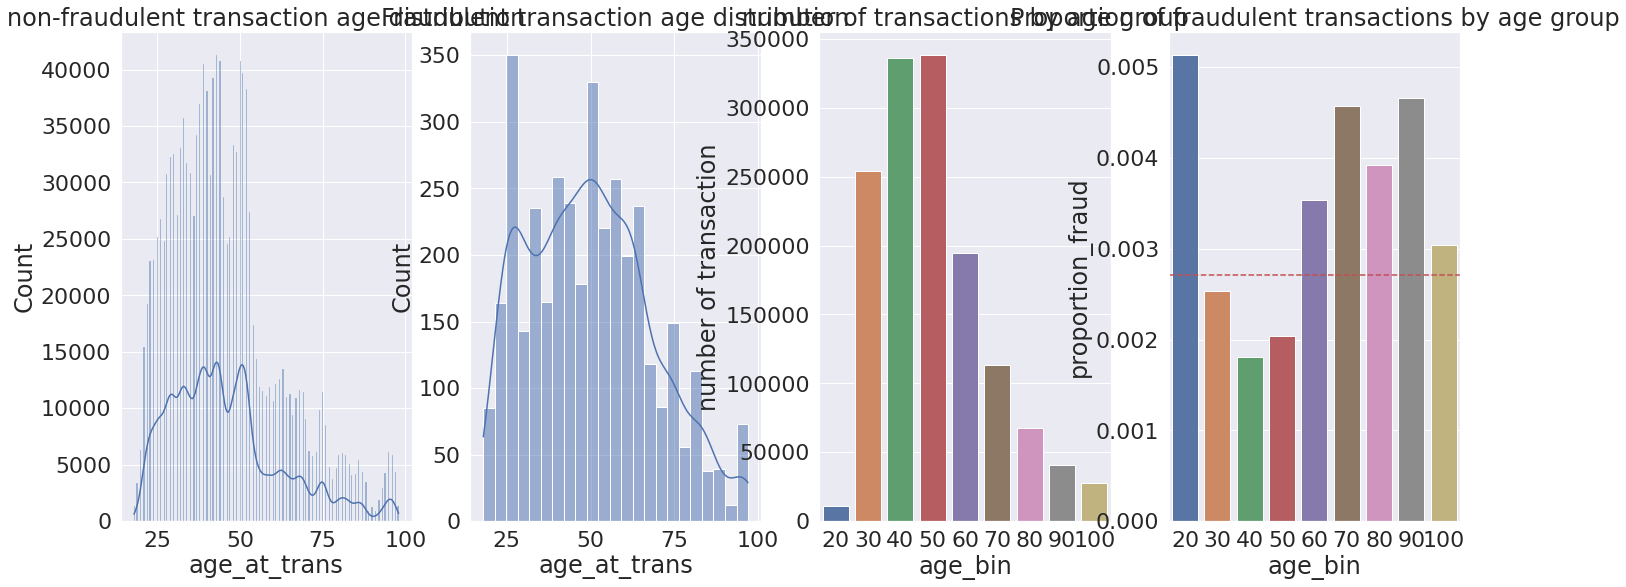

In [106]:
fig,ax = plt.subplots(1,4,figsize = (24,9))
mask = df['is_fraud'] == 0
sns.histplot(df[mask]['age_at_trans'],kde=True , ax = ax[0])
ax[0].set_title('non-fraudulent transaction age distribution')
mask = df['is_fraud'] == 1
sns.histplot(df[mask]['age_at_trans'],kde=True,ax = ax[1])
ax[1].set_title('Fraudulent transaction age distribution')
sns.barplot(data = age_exp, y = 'num_of_trans_x' , x = 'age_bin' , ax = ax[2])
ax[2].set_title('number of transactions by age group')
ax[2].set_ylabel('number of transaction')
sns.barplot(data = age_exp, y = 'proportion_fraud' , x = 'age_bin' , ax = ax[3])
ax[3].set_title('Proportion of fraudulent transactions by age group')
ax[3].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

Proportion of fraudulent transactions differs slightly between each age group. Seems like people between the age of 20 to 50 are the slightl less likely to be victim of fraud.

In [107]:
temp_1 = df['trans_month'].value_counts().reset_index().rename(columns = {'index':'month','trans_month':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['trans_month'].value_counts().reset_index().rename(columns = {'index':'month','trans_month':'num_transaction'})
month_exp = temp_1.merge(temp_2, how = 'left', on = 'month')
month_exp['proportion_fraud'] = month_exp['num_transaction_y']/month_exp['num_transaction_x']

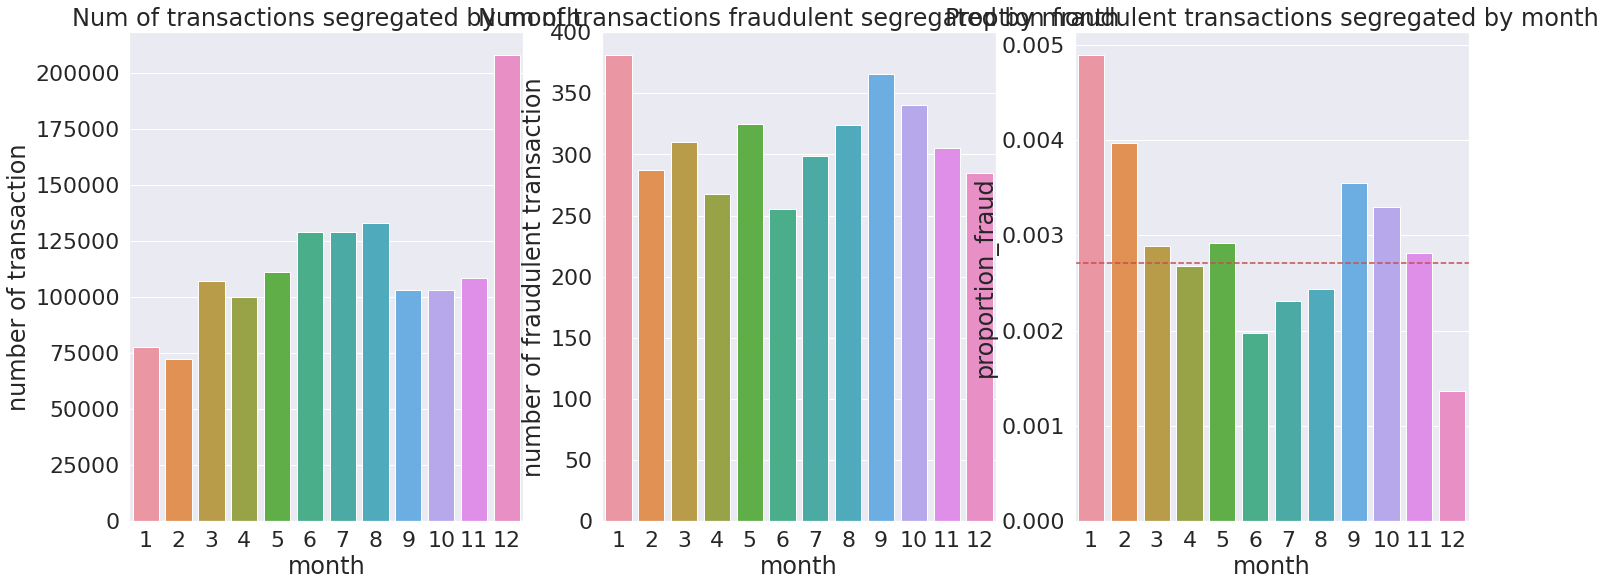

In [108]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = month_exp, y = 'num_transaction_x' , x = 'month' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by month')
sns.barplot(data = month_exp, y = 'num_transaction_y' , x = 'month' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by month')
sns.barplot(data = month_exp, y = 'proportion_fraud' , x = 'month' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by month')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

In [109]:
df.groupby('trans_month').agg({'is_fraud':[np.mean,np.std,np.count_nonzero,np.shape]})

is_fraud                                   
                 mean       std count_nonzero      shape
trans_month                                             
1            0.004888  0.069742           381   (77950,)
2            0.003964  0.062832           287   (72410,)
3            0.002889  0.053672           310  (107302,)
4            0.002675  0.051649           268  (100197,)
5            0.002925  0.054001           325  (111127,)
6            0.001976  0.044410           255  (129041,)
7            0.002314  0.048044           299  (129239,)
8            0.002434  0.049277           324  (133105,)
9            0.003545  0.059432           366  (103254,)
10           0.003299  0.057346           340  (103049,)
11           0.002814  0.052972           305  (108389,)
12           0.001371  0.037002           285  (207875,)

1. We can observe that there's a spike in number of transactions in the month of December, this may be due to christmas/thanksgiving spending.
2. We can observe that number of fraudulent transactions remains relatively even over the months, even though there's a tremendous spike in transaction volumne in December and a dip in Jan and Feb.

In [110]:
temp_1 = df['weekday'].value_counts().reset_index().rename(columns = {'index':'weekday','weekday':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['weekday'].value_counts().reset_index().rename(columns = {'index':'weekday','weekday':'num_transaction'})
day_exp = temp_1.merge(temp_2, how = 'left', on = 'weekday')
day_exp['proportion_fraud'] = day_exp['num_transaction_y']/day_exp['num_transaction_x']

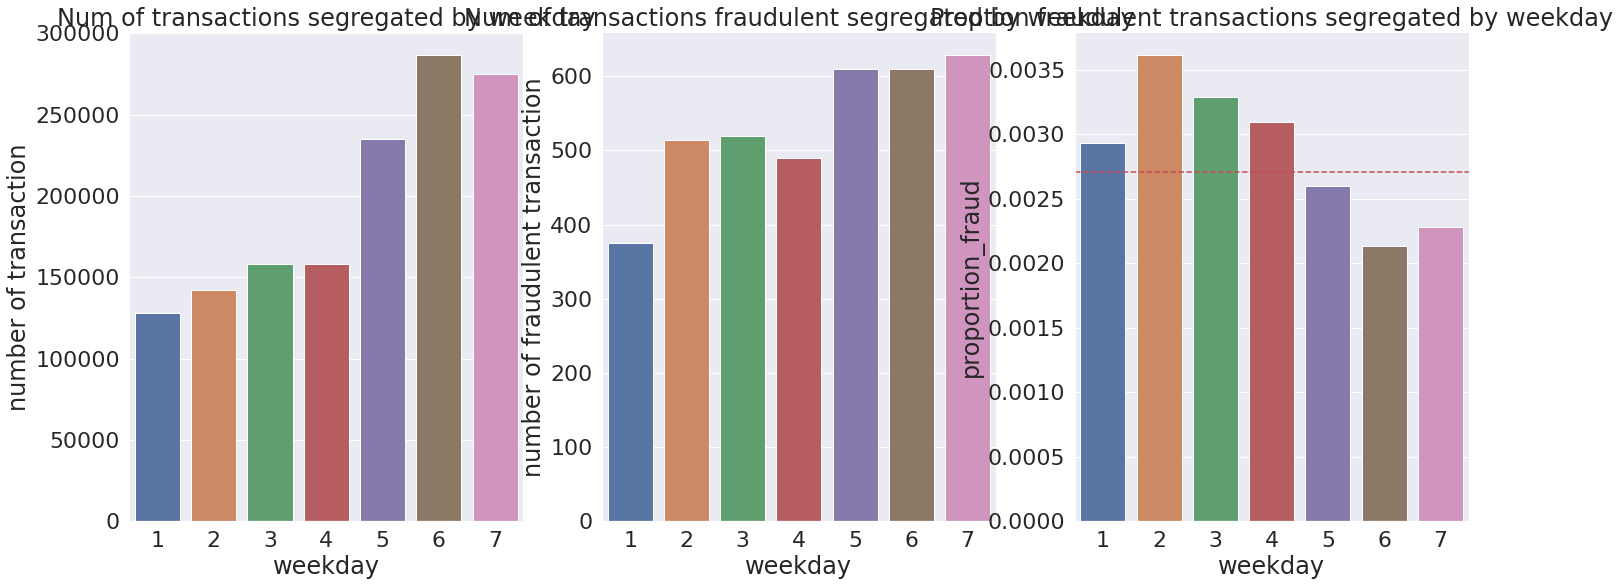

In [111]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = day_exp, y = 'num_transaction_x' , x = 'weekday' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by weekday')
sns.barplot(data = day_exp, y = 'num_transaction_y' , x = 'weekday' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by weekday')
sns.barplot(data = day_exp, y = 'proportion_fraud' , x = 'weekday' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by weekday')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

In [112]:
df.groupby(['weekday','trans_year']).agg({'is_fraud':[np.mean,np.std,np.count_nonzero,np.shape],
                                          'amt':[np.mean,np.median,np.std,np.min,np.max]})

is_fraud                          ...         amt               
                        mean       std count_nonzero  ...         std amin      amax
weekday trans_year                                    ...                           
1       2012        0.003053  0.055169           130  ...  157.398168  1.0   9509.61
        2013        0.003160  0.056125           135  ...  142.445833  1.0   6666.80
        2014        0.002576  0.050685           110  ...  159.054076  1.0  10322.94
2       2012        0.003862  0.062026           180  ...  148.390596  1.0   8960.68
        2013        0.003830  0.061768           185  ...  156.293111  1.0  14528.15
        2014        0.003138  0.055931           149  ...  196.610388  1.0  23155.51
3       2012        0.003224  0.056689           168  ...  155.401668  1.0  13419.49
        2013        0.003718  0.060866           194  ...  152.161063  1.0  16784.15
        2014        0.002924  0.053992           157  ...  151.811251  1.0   9115.52
4       2012        0.002838  0.053202           150  ...  145.956328  1.0  10328.33
        2013        0.003146  0.056001           166  ...  147.915960  1.0  10306.14
        2014        0.003295  0.057311           173  ...  179.042483  1.0  22751.93
5       2012        0.002395  0.048879           191  ...  148.870740  1.0   9741.95
        2013        0.002876  0.053554           224  ...  145.037437  1.0  10259.67
        2014        0.002524  0.050177           195  ...  142.467640  1.0   9464.29
6       2012        0.001688  0.041057           162  ...  149.480642  1.0  13085.67
        2013        0.002503  0.049971           241  ...  149.930227  1.0  11043.48
        2014        0.002198  0.046827           207  ...  192.904524  1.0  20705.04
7       2012        0.002163  0.046458           199  ...  164.171153  1.0  20245.82
        2013        0.002633  0.051249           241  ...  188.399153  1.0  22729.82
        2014        0.002052  0.045253           188  ...  146.789461  1.0  15329.82

[21 rows x 9 columns]

1. Most transactions occurs over the weekends.
2. There seems to be more fraudulent transactions that occurs during the weekends
3. However proprotion of fraudulent transaction seems to be more during the weekdays.

In [113]:
temp_1 = df['merchant'].value_counts().reset_index().rename(columns = {'index':'merchant','merchant':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['merchant'].value_counts().reset_index().rename(columns = {'index':'merchant','merchant':'num_transaction'})
merc_exp = temp_1.merge(temp_2, how = 'left', on = 'merchant')
merc_exp['proportion_fraud'] = merc_exp['num_transaction_y']/merc_exp['num_transaction_x']
merc_exp.fillna(0,inplace = True)
merc_exp.sort_values(by = 'num_transaction_y', inplace = True)

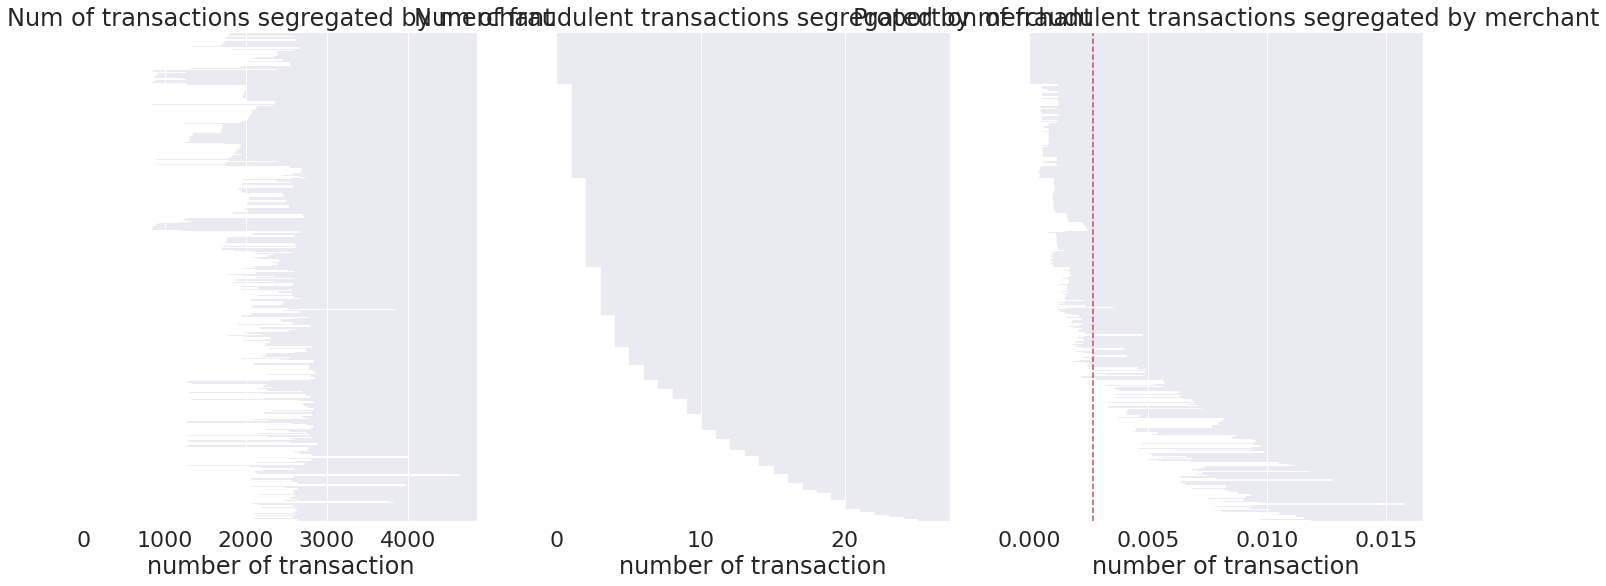

In [114]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = merc_exp, x = 'num_transaction_x' , y = 'merchant' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by merchant')
ax[0].yaxis.set_visible(False)

sns.barplot(data = merc_exp, x = 'num_transaction_y' , y = 'merchant' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by merchant')
ax[1].yaxis.set_visible(False)

sns.barplot(data = merc_exp, x = 'proportion_fraud' , y = 'merchant' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('number of transaction')
ax[2].set_title('Proportion of fraudulent transactions segregated by merchant')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [115]:
merc_agg = df.groupby('merchant').agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]})

In [116]:
merc_agg.sort_values(by = ('is_fraud','mean'), ascending = False).head(10)

is_fraud                             
                                     sum      mean       std    shape
merchant                                                             
Mante Group                           20  0.015760  0.124596  (1269,)
Kerluke PLC                           16  0.012749  0.112234  (1255,)
Price Inc                             26  0.011856  0.108262  (2193,)
Gerlach Inc                           25  0.011832  0.108153  (2113,)
Hayes, Marquardt and Dibbert          15  0.011755  0.107826  (1276,)
Labadie, Treutel and Bode             24  0.011527  0.106771  (2082,)
Gottlieb, Considine and Schultz       24  0.011472  0.106518  (2092,)
Lemke-Gutmann                         23  0.011176  0.105149  (2058,)
Moore, Dibbert and Koepp              14  0.011085  0.104740  (1263,)
Flatley-Durgan                        14  0.010878  0.103769  (1287,)

1. There seems to be some merchants that are being targeted.
2. Categorization may be necessary to simplify this feature
3. A possibe solution may be to make it an ordinal feature, base on risk category of these merchants

In [117]:
temp_1 = df['cc_num'].value_counts().reset_index().rename(columns = {'index':'cc_num','cc_num':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['cc_num'].value_counts().reset_index().rename(columns = {'index':'cc_num','cc_num':'num_transaction'})
cc_exp = temp_1.merge(temp_2, how = 'left', on = 'cc_num')
cc_exp['proportion_fraud'] = cc_exp['num_transaction_y']/cc_exp['num_transaction_x']
cc_exp.fillna(0,inplace = True)
cc_exp.sort_values(by = 'num_transaction_x', inplace = True) 

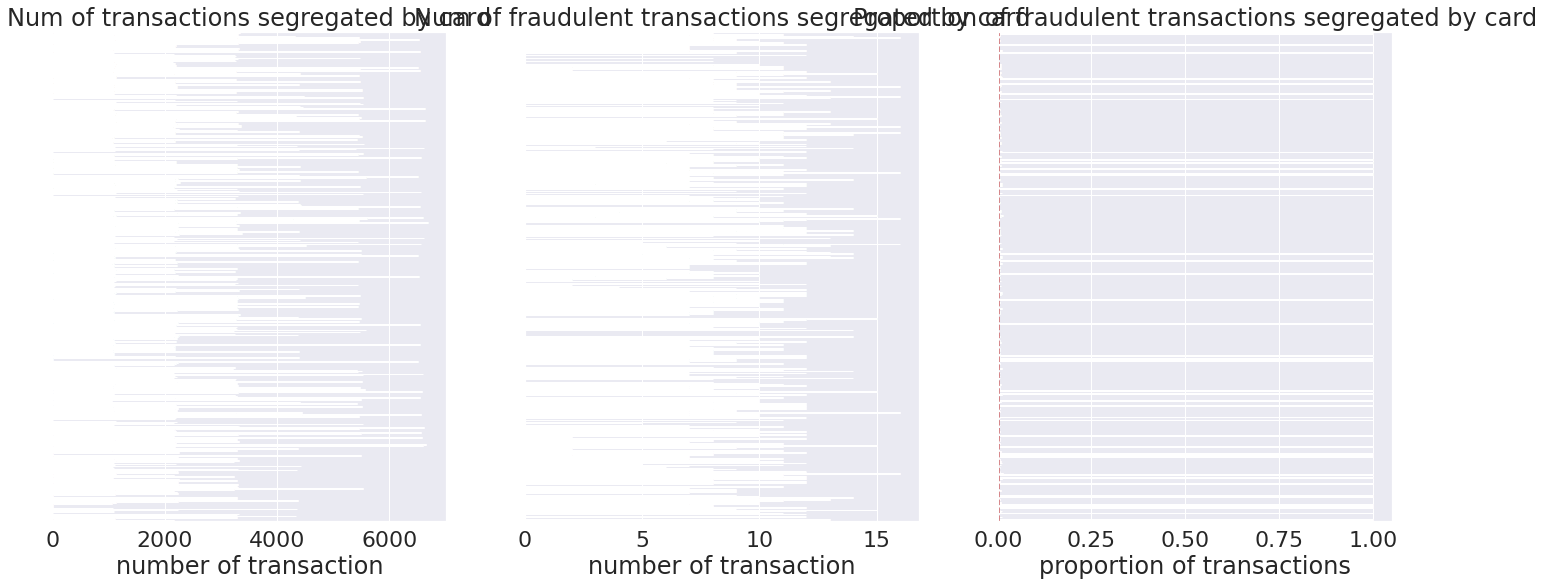

In [118]:
fig,ax = plt.subplots(1,3,figsize = (24,9)) #why is it not sorting???
sns.barplot(data = cc_exp, x = 'num_transaction_x' , y = 'cc_num' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by card')
ax[0].yaxis.set_visible(False)

sns.barplot(data = cc_exp, x = 'num_transaction_y' , y = 'cc_num' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by card')
ax[1].yaxis.set_visible(False)

sns.barplot(data = cc_exp, x = 'proportion_fraud' , y = 'cc_num' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('Proportion of fraudulent transactions segregated by card')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [119]:
len(cc_exp[cc_exp['proportion_fraud']==1])/len(cc_exp)

0.092

All transactions from these cards are all fraudulent, and they represent 9.2% of all credit cards.

In [120]:
temp_1 = df['category'].value_counts().reset_index().rename(columns = {'index':'category','category':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['category'].value_counts().reset_index().rename(columns = {'index':'category','category':'num_transaction'})
cat_exp = temp_1.merge(temp_2, how = 'left', on = 'category')
cat_exp['proportion_fraud'] = cat_exp['num_transaction_y']/cat_exp['num_transaction_x']

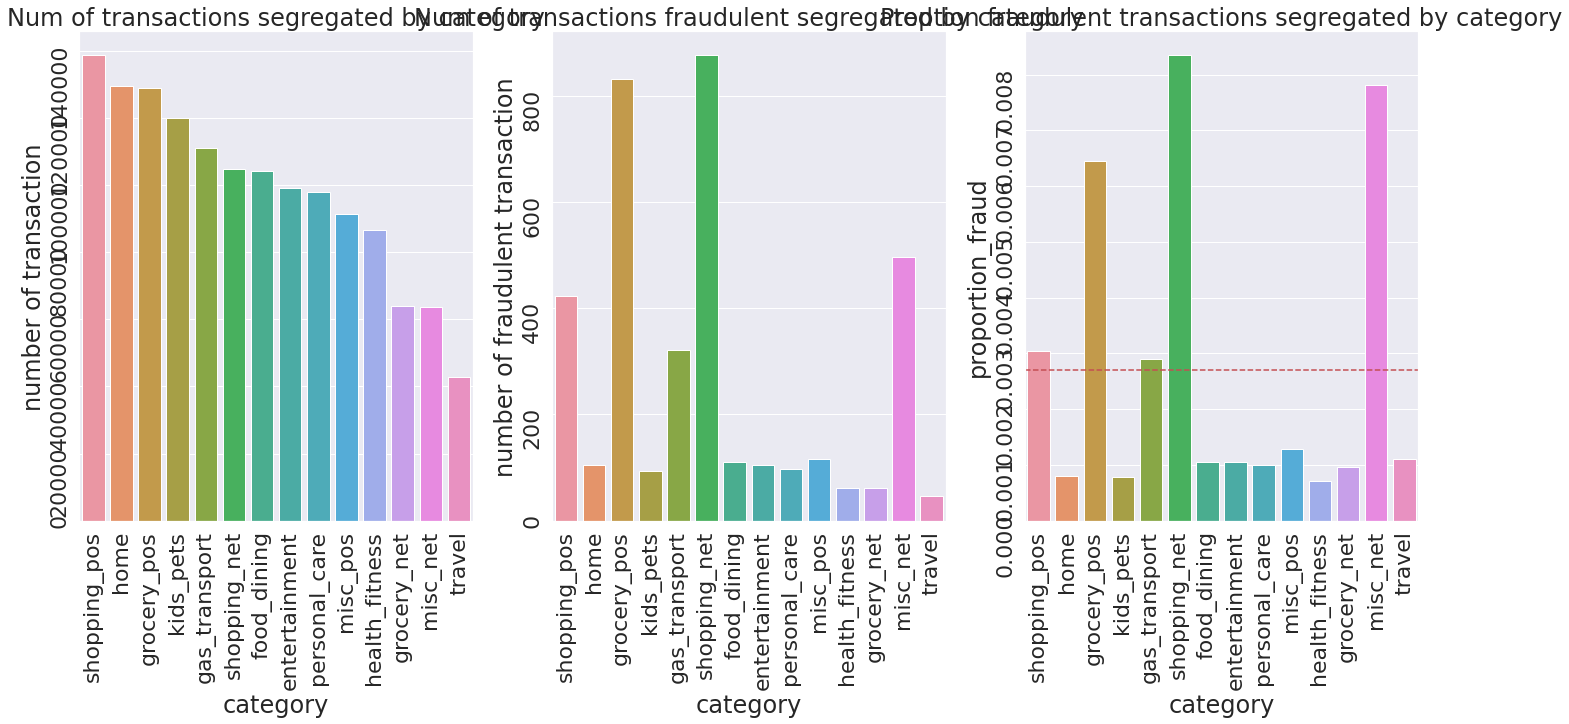

In [121]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = cat_exp, y = 'num_transaction_x' , x = 'category' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by category')
ax[0].tick_params(labelrotation=90)

sns.barplot(data = cat_exp, y = 'num_transaction_y' , x = 'category' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by category')
ax[1].tick_params(labelrotation=90)

sns.barplot(data = cat_exp, y = 'proportion_fraud' , x = 'category' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by category')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")
ax[2].tick_params(labelrotation=90)

In [122]:
double_cat = list(df.groupby(['merchant','category']).agg({'is_fraud':'sum'}).reset_index()['merchant'].value_counts().reset_index().head(7)['index'])
df.loc[df['merchant'].isin(double_cat)].groupby(['merchant','category']).agg({'is_fraud':['sum','mean','count']})

is_fraud                
                                   sum      mean count
merchant       category                               
Boyer PLC      misc_pos              1  0.000543  1843
               shopping_net         16  0.007533  2124
Cormier LLC    health_fitness        1  0.000573  1744
               shopping_net         19  0.009135  2080
Dickinson Ltd  misc_pos              1  0.000543  1842
               personal_care         2  0.001001  1998
Gislason Group misc_pos              1  0.000528  1893
               travel                0  0.000000   843
Kilback LLC    food_dining           5  0.002380  2101
               grocery_pos          11  0.004355  2526
Kuhn LLC       misc_net              7  0.005529  1266
               shopping_pos          7  0.002569  2725
Schumm PLC     health_fitness        1  0.000584  1713
               shopping_net         19  0.009228  2059

In [123]:
df.groupby(['merchant']).agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]}).shape, df.groupby(['merchant','category']).agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]}).shape
#looks like a very small number of merchants are categorised under 2 different cateogries

((693, 4), (700, 4))

1.Grocery POS, Shopping POS , Shopping Net, MISC Net and Gas Transport seems to be disproportionately targeted for fraudulent activities.

In [124]:
temp_1 = df['job'].value_counts().reset_index().rename(columns = {'index':'job','job':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['job'].value_counts().reset_index().rename(columns = {'index':'job','job':'num_transaction'})
job_exp = temp_1.merge(temp_2, how = 'left', on = 'job')
job_exp['proportion_fraud'] = (job_exp['num_transaction_y'])/(job_exp['num_transaction_x'])
job_exp.fillna(0,inplace = True)
job_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

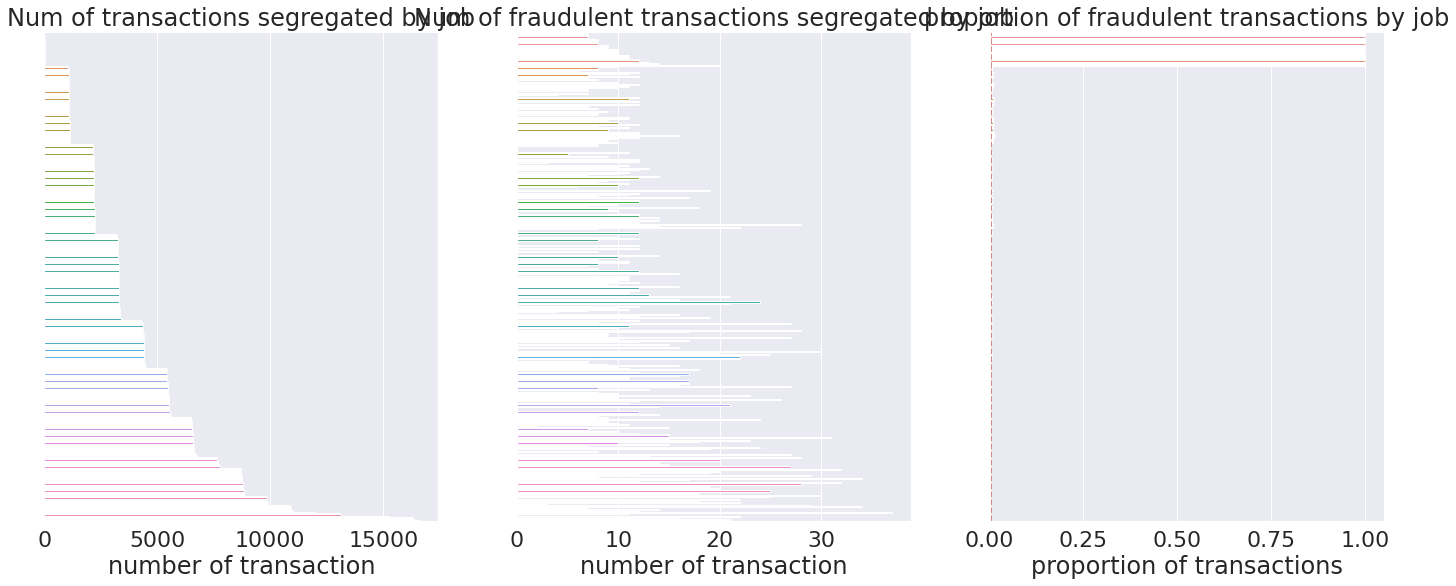

In [125]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = job_exp, x = 'num_transaction_x' , y = 'job' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by job')
ax[0].yaxis.set_visible(False)

sns.barplot(data = job_exp, x = 'num_transaction_y' , y = 'job' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by job')
ax[1].yaxis.set_visible(False)

sns.barplot(data = job_exp, x = 'proportion_fraud' , y = 'job' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by job')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

1. There seems to be a group of job titles that are held by a small proportion of the population that seems to be targeted for fraudulent activities
2. The high cardinaity of this feature may be problematic for the model learning process, as some of the groups in the category has very small samples to learn from.
3. Proposed solution : use of target encoding to flag out these highly risky cards.

In [126]:
temp_1 = df['hour'].value_counts().reset_index().rename(columns = {'index':'hour','hour':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['hour'].value_counts().reset_index().rename(columns = {'index':'hour','hour':'num_transaction'})
time_exp = temp_1.merge(temp_2, how = 'left', on = 'hour')
time_exp['proportion_fraud'] = (time_exp['num_transaction_y'])/(time_exp['num_transaction_x'])
time_exp.fillna(0,inplace = True)
time_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

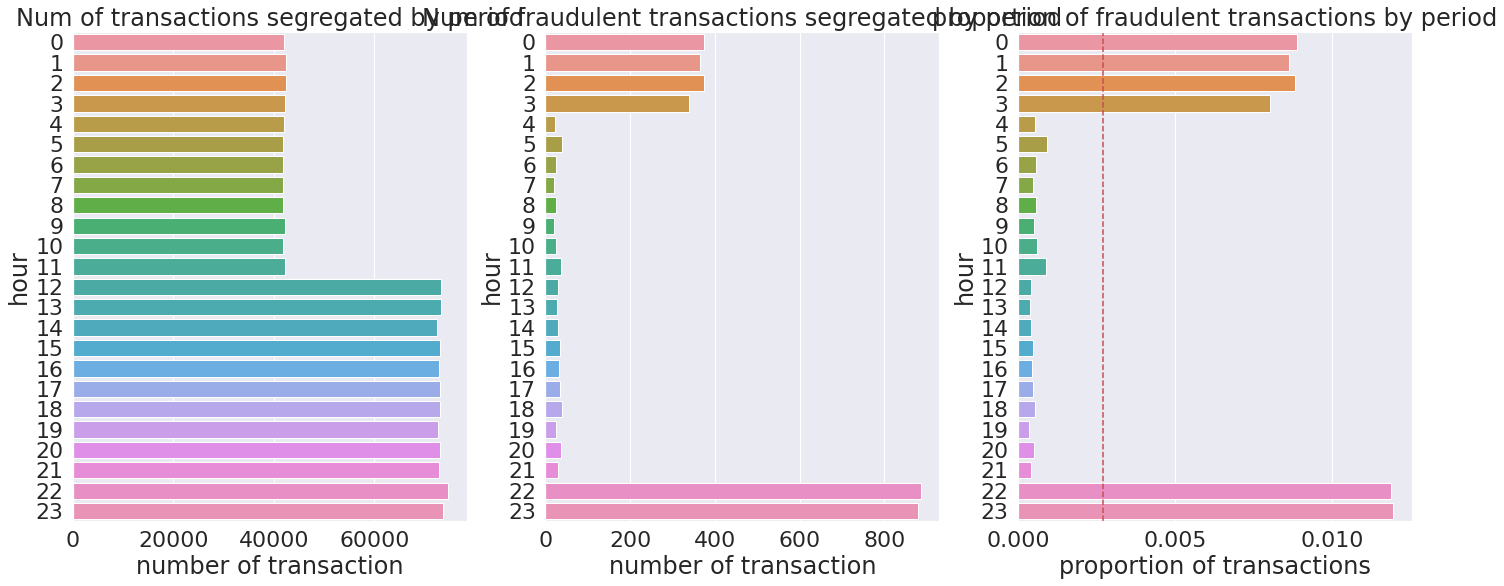

In [127]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = time_exp, x = 'num_transaction_x' , y = 'hour' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by period')
#ax[0].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'num_transaction_y' , y = 'hour' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by period')
#ax[1].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'proportion_fraud' , y = 'hour' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by period')
#ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [128]:
df_test = pd.read_csv('test_ts.csv')
df_test.loc[:,'trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.sort_values(by = 'trans_date_time' , inplace = True)
df_test.set_index('trans_date_time', inplace = True)

In [129]:
df_test = age_bin(df_test)

In [130]:
def time_risk(df_):
  x = df_['hour']
  condlist = [x<4,x>21,(x>=4) & (x<=21)]
  choicelist = [1,1,0]
  df_['time_risk'] = np.select(condlist,choicelist)

  return df_

In [131]:
df = time_risk(df)
df_test = time_risk(df_test)

In [132]:
temp_1 = df['time_risk'].value_counts().reset_index().rename(columns = {'index':'time_risk','time_risk':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['time_risk'].value_counts().reset_index().rename(columns = {'index':'time_risk','time_risk':'num_transaction'})
time_exp = temp_1.merge(temp_2, how = 'left', on = 'time_risk')
time_exp['proportion_fraud'] = (time_exp['num_transaction_y'])/(time_exp['num_transaction_x'])
time_exp.fillna(0,inplace = True)
time_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

1. Simplifying time feature to binary

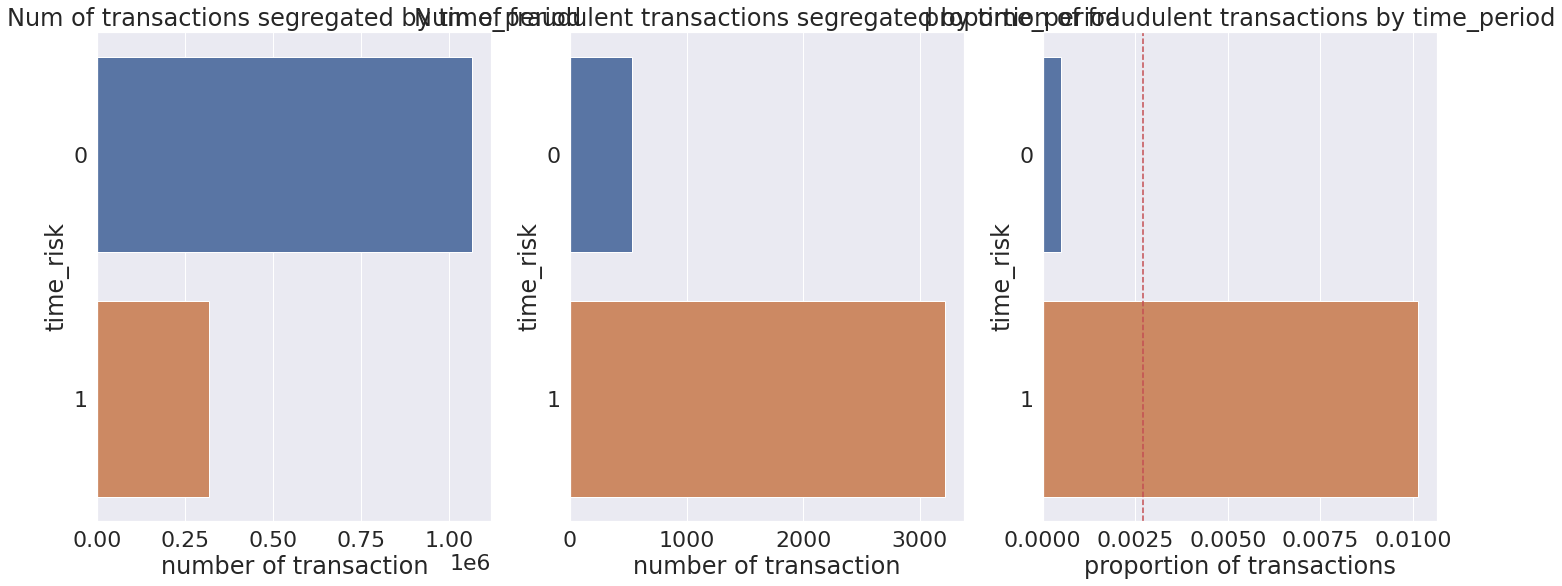

In [133]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = time_exp, x = 'num_transaction_x' , y = 'time_risk' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by time_period')
#ax[0].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'num_transaction_y' , y = 'time_risk' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by time_period')
#ax[1].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'proportion_fraud' , y = 'time_risk' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by time_period')
#ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

### Feature Engineering

### Feature 1 : distance from cardholder's address and merchant

In [134]:
#from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [135]:
 def cardholder_to_merc_dist(df_): 
  dist = haversine(df_['lat'].values,df_['long'].values,
                   df_['merch_lat'].values,df_['merch_long'].values)
  
  df_['cardholder_to_merc_dist']  = dist
  return df_

In [136]:
df = cardholder_to_merc_dist(df)
df_test = cardholder_to_merc_dist(df_test)

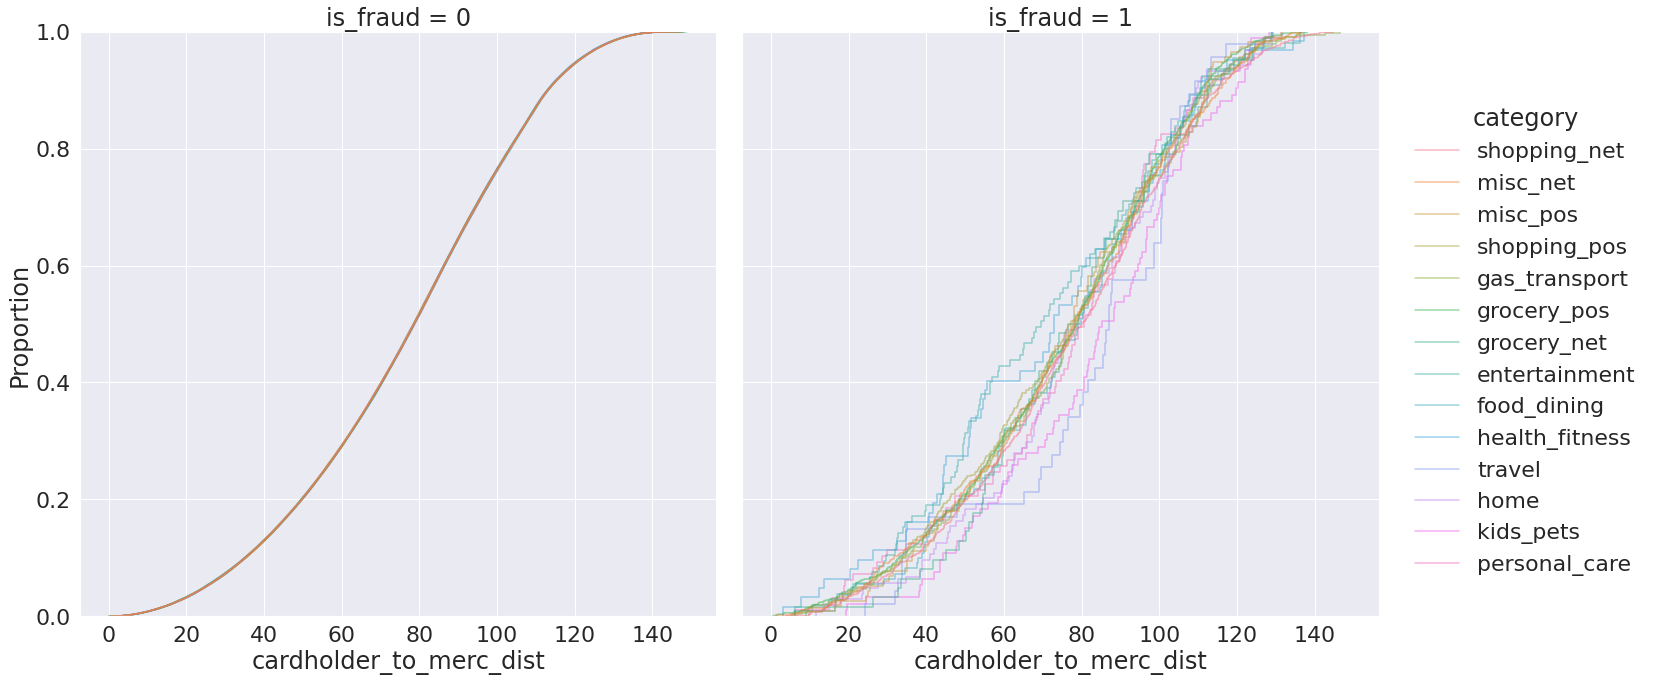

In [137]:
sns.displot(data = df.reset_index() , 
            x = 'cardholder_to_merc_dist' ,
            hue = 'category',
            col = 'is_fraud',
            alpha = 0.5 , 
            height = 10,
            aspect = 1,
            kind = 'ecdf' ) # seems like no matter which category, the distribution for 'the distance from the cardholder's registered address to the merchant' is the same.

### Feature 2 : rolling average of each card's total daily transaction amount  in the last x days

In [138]:
def num_trans_last_xdays(df_,x):
  df_['trans_date'] = pd.to_datetime(df_['trans_date']) # making sure 'trans_date' is in datetime format
  if df_.index.dtype == '<M8[ns]':
    df_.reset_index(inplace = True)
    
  cc_list = list(df_['cc_num'].unique())
  df_temp =pd.DataFrame({})

  for cc_num in cc_list: #run through each credit card individually
    mask = df_['cc_num'] == cc_num
    temp_agg =  df_[mask].groupby('trans_date').agg({'amt':np.sum})
    temp_agg.rename(columns = {'amt':'total_amt'} , inplace = True)
    temp_agg['cc_num'] = cc_num
    temp_agg[f'ma_{x}d_mean'] = temp_agg['total_amt'].rolling(f'{x}d').mean() 
    temp_agg[f'ma_{x}d_std'] = temp_agg['total_amt'].rolling(f'{x}d').std()
    temp_agg[f'ewm_{x}d_mean'] = temp_agg['total_amt'].ewm(x).mean()
    temp_agg[f'ewm_{x}d_std'] = temp_agg['total_amt'].ewm(x).std()
    temp_agg.reset_index(inplace = True)
    temp_agg.fillna(0,inplace = True) #standard deviation will return NAN for all the first transaction in the dataset ; impute with 0.
    df_temp= pd.concat([df_temp,temp_agg]) #dd result into temporary dataframe.
  
  df_ = df_.merge(right = df_temp, how = 'left', on = ['trans_date','cc_num'])
  df_[f'trans_flag_{x}d_ma'] = np.where(df_['total_amt'] > (df_[f'ma_{x}d_mean'] + 5*df_[f'ma_{x}d_std']),1,0)
  df_[f'trans_flag_{x}d_ewm'] = np.where(df_['total_amt'] > (df_[f'ewm_{x}d_mean'] + 5*df_[f'ewm_{x}d_std']),1,0)

  df_.drop(columns = [f'ma_{x}d_mean',f'ma_{x}d_std',f'ewm_{x}d_mean',f'ewm_{x}d_std'] , axis = 'columns' , inplace = True)
  return df_

In [139]:
#as past data should be available at the point where predictions are to be made, I will be combining the 2015 data with 2012 - 2014 data to compute the moving window values 
df_temp = num_trans_last_xdays(pd.concat([df,df_test]),60)
df_temp.sort_values(by = 'trans_date_time', inplace = True)
df_temp.set_index('trans_date_time', inplace = True)
df = df_temp['2012':'2014']
df_test = df_temp['2015']

del df_temp #garbage collection

### Anomaly Detection with exponential weighted moving average total daily transaction amount

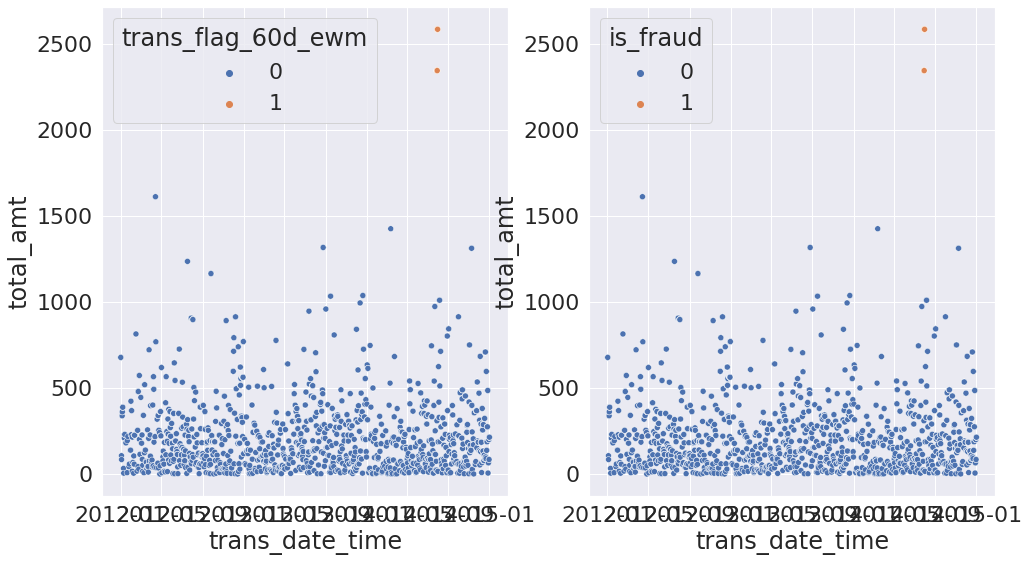

In [140]:
fig , ax = plt.subplots(1,2,figsize = (16,9))
cc_list = list(df['cc_num'].unique())
mask = df['cc_num'] == cc_list[15]
sns.scatterplot(data = df[mask], x = df[mask].index , y = 'total_amt',hue = 'trans_flag_60d_ewm' , ax = ax[0])
sns.scatterplot(data = df[mask], x = df[mask].index , y = 'total_amt',hue = 'is_fraud' , ax = ax[1])

### Feature 3 : Flagging high risk transaction values

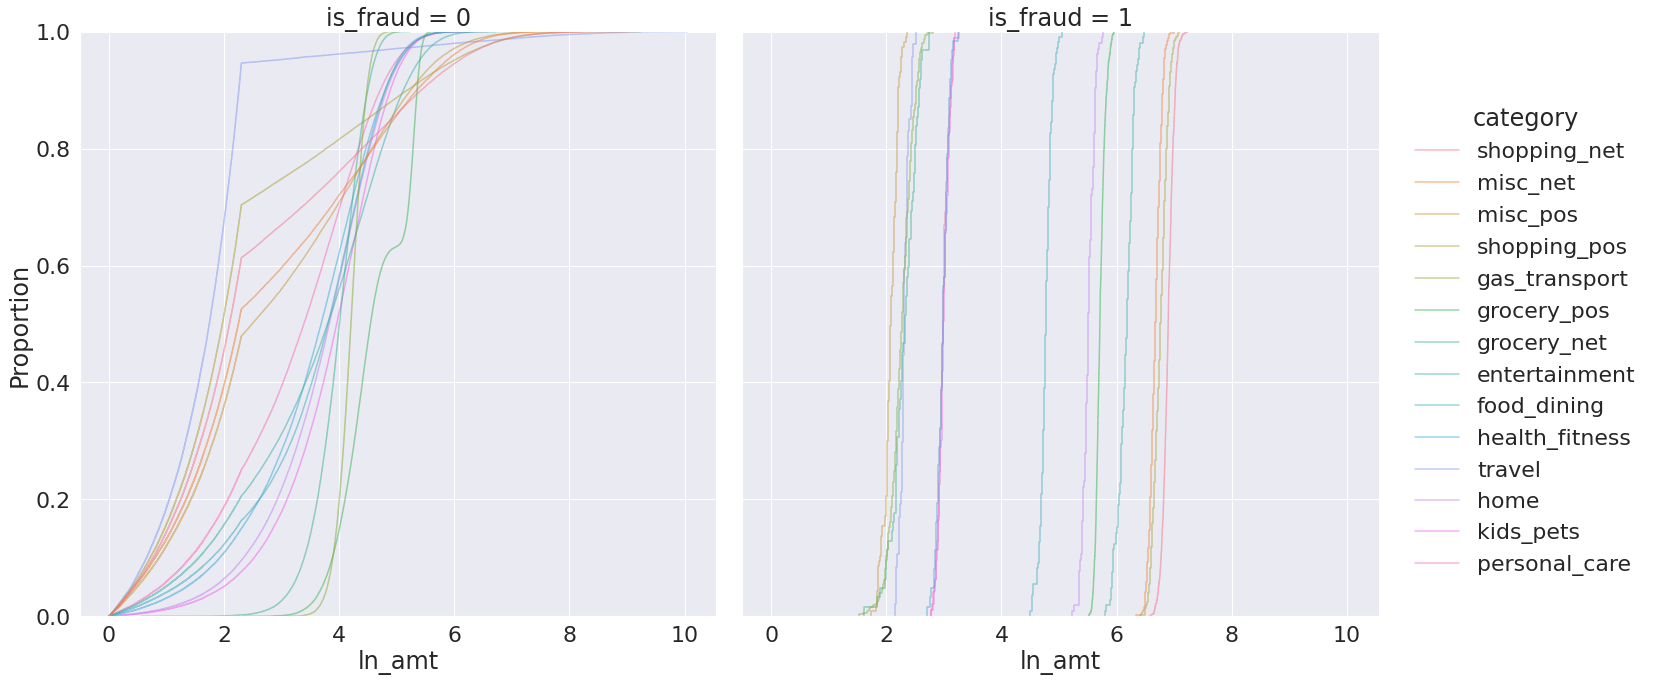

In [141]:
df['ln_amt'] = np.log(df['amt'])
sns.set(font_scale=2) 
sns.displot(data = df.reset_index() , 
            x = 'ln_amt' ,
            hue = 'category',
            col = 'is_fraud',
            alpha = 0.5 , 
            height = 10,
            aspect = 1,
            kind = 'ecdf' ) 

1.Visually we can see that the distribution of transactions for each categories are sightly different, and that each of them has a very wide variance. 

2.However, it seems like fraudulent transactions from each category has a very small variance,, with different means for each categories. Assuming that the distribution of fraudulent transactions in the near future will be similar, we can encode this information as a feature, and use it as a risk indicator.

In [142]:
def flag_cat_amt(df_train,df_test):
  df_train['ln_amt'] = np.log(df_train['amt'])
  df_test['ln_amt'] = np.log(df_test['amt'])

  temp_list = []

  mask = df_train['is_fraud']==1
  cat_list = df_train['category'].unique()
  cat_store = []

  df_train_temp = pd.DataFrame({})
  df_test_temp = pd.DataFrame({})
  for cat in cat_list:
    mask1 = df_train['category'] == cat

    x_90 = df_train[mask&mask1]['ln_amt'].quantile(q=0.90) 
    x_25 = df_train[mask&mask1]['ln_amt'].quantile(q=0.25)

    df_train[f'{cat}_0.9q'] = x_90
    df_train[f'{cat}_0.25q'] = x_25

    df_test[f'{cat}_0.9q'] = x_90
    df_test[f'{cat}_0.25q'] = x_25


    cat_store.append(f'{cat}_0.9q')
    cat_store.append(f'{cat}_0.25q')

  for cat in cat_list:
    mask1 = df_train['category'] == cat 
    temp_train_df = df_train[mask1].copy()
    temp_train_df['flag_cat_amt'] = None
    temp_train_df['flag_cat_amt'] = np.where((temp_train_df['ln_amt']>=temp_train_df[f'{cat}_0.25q']) & (temp_train_df['ln_amt']<=temp_train_df[f'{cat}_0.9q']),
                                             1,0)
    
    mask1 = df_test['category'] == cat 
    temp_test_df = df_test[mask1].copy()
    temp_test_df['flag_cat_amt'] = None
    temp_test_df['flag_cat_amt'] = np.where((temp_test_df['ln_amt']>=temp_test_df[f'{cat}_0.25q']) & (temp_test_df['ln_amt']<=temp_test_df[f'{cat}_0.9q']),
                                             1,0)
    
    df_train_temp = pd.concat([df_train_temp,temp_train_df])
    df_test_temp = pd.concat([df_test_temp,temp_test_df])



  df_train_temp.drop(columns = cat_store , axis = 'columns' , inplace = True)
  df_test_temp.drop(columns = cat_store , axis = 'columns' , inplace = True)
  
  return df_train_temp, df_test_temp

In [143]:
df , df_test = flag_cat_amt(df,df_test)

### Feature 4 : 5 days rolling average of each card segregated by their categories.

In [177]:
def total_trans_last_ydays_cat(df_,y):
  df_['trans_date'] = pd.to_datetime(df_['trans_date']) # making sure 'trans_date' is in datetime format
  if df_.index.dtype == '<M8[ns]':
    df_.reset_index(inplace = True)
    
  cc_list = list(df_['cc_num'].unique())
  cat_list = list(df_['category'].unique())
  cat_tt = {}

  for cat in cat_list: #run through each category
    df_temp =pd.DataFrame({})
    mask = df_['category'] == cat
    temp_df = df_[mask]

    for cc_num in cc_list:  #getting a rolling average based on each category

      mask = temp_df['cc_num'] == cc_num
      temp_agg =  temp_df[mask].groupby('trans_date').agg({'amt':np.sum})
      temp_agg.rename(columns = {'amt':'cat_total_amt'} , inplace = True)
      temp_agg[f'ma_{y}d_mean'] = temp_agg['cat_total_amt'].rolling(f'{y}d').mean() #get a 5 days moving average approach
      temp_agg[f'ma_{y}d_std'] = temp_agg['cat_total_amt'].rolling(f'{y}d').std()
      temp_agg[f'ewm_{y}d_mean'] = temp_agg['cat_total_amt'].ewm(y).mean()
      temp_agg[f'ewm_{y}d_std'] = temp_agg['cat_total_amt'].ewm(y).std()
      temp_agg['cc_num'] = cc_num
      temp_agg['category'] = cat
      temp_agg = temp_agg.reset_index()
      df_temp = pd.concat([df_temp,temp_agg]) #dd result into temporary dataframe.
    cat_tt[f'{cat}'] = df_temp.copy()
  df_temp = pd.concat(cat_tt.values(),ignore_index=True).fillna(0)
  df_ = df_.merge(right = df_temp, how = 'left', on = ['trans_date','cc_num','category']) #once done it'll merge with the main dataframe
    
  return df_

In [151]:
  y = 5
  df['trans_date'] = pd.to_datetime(df['trans_date'])
  cc_list = list(df['cc_num'].unique())
  cat_list = list(df['category'].unique())
  cat_tt = {}

  for cat in cat_list: #run through each category
    df_temp =pd.DataFrame({})
    mask = df['category'] == cat
    temp_df = df[mask]

    for cc_num in cc_list:  #getting a rolling average based on each category

      mask = temp_df['cc_num'] == cc_num
      temp_agg =  temp_df[mask].groupby('trans_date').agg({'amt':np.sum})
      temp_agg.rename(columns = {'amt':'cat_total_amt'} , inplace = True)
      temp_agg[f'ma_{y}d_mean'] = temp_agg['cat_total_amt'].rolling(f'{y}d').mean() #get a 5 days moving average approach
      temp_agg[f'ma_{y}d_std'] = temp_agg['cat_total_amt'].rolling(f'{y}d').std()
      temp_agg[f'ewm_{y}d_mean'] = temp_agg['cat_total_amt'].ewm(y).mean()
      temp_agg[f'ewm_{y}d_std'] = temp_agg['cat_total_amt'].ewm(y).std()
      temp_agg['cc_num'] = cc_num
      temp_agg['category'] = cat
      temp_agg = temp_agg.reset_index()
      df_temp = pd.concat([df_temp,temp_agg]) #dd result into temporary dataframe.
    cat_tt[f'{cat}'] = df_temp.copy()
  df_temp = pd.concat(cat_tt.values(),ignore_index=True).fillna(0)
  test = df.copy().merge(right = df_temp, how = 'left', on = ['trans_date','cc_num','category'])
 

In [178]:
#as past data should be available at the point where predictions are to be made, I will be combining the 2015 data with 2012 - 2014 data to compute the moving window values 
df_temp = total_trans_last_ydays_cat(pd.concat([df,df_test]),5)
df_temp.sort_values(by = 'trans_date_time', inplace = True)
df_temp.set_index('trans_date_time', inplace = True)
df = df_temp['2012':'2014']
df_test = df_temp['2015']

#del df_temp #garbage collection

In [182]:
df.drop(columns = df.columns[-5:], axis = 'columns', inplace = True)
df_test.drop(columns = df_test.columns[-5:], axis = 'columns', inplace = True)

In [181]:
df_temp.head(5)

,trans_date_time,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_month,weekday,hour,day,age_at_trans,name,age_bin,time_risk,cardholder_to_merc_dist,total_amt,trans_flag_60d_ma,trans_flag_60d_ewm,ln_amt,flag_cat_amt,cat_total_amt,ma_5d_mean,ma_5d_std,ewm_5d_mean,ewm_5d_std
0,2012-01-01 00:01:12,415-30-6045,4185030097518516435,Julie,Johnston,F,9623 Jennifer Hill,Burlington,KS,66839,38.2363,-95.7336,4007,Network engineer,1931-12-21,213902183939,c7cc68c7ab6c50973d25962f669dd37f,2012-01-01,00:01:12,1325376072,shopping_net,3.19,0,Gerlach Inc,38.454937,-95.797548,2012,1,7,0,1,80.0,Julie Johnston,80,1,24.942755,194.75,0,0,1.160021,0,3.19,3.19,0.0,3.19,0.0
1,2012-01-01 00:01:55,739-34-6975,213122912901076,Robert,Clark,M,098 Marshall Prairie Suite 299,Rancho Cucamonga,CA,91730,34.1070,-117.5941,101719,Broadcast engineer,1970-08-01,191678637199,16eb5e89ec031195ccaf89ac2a0a28d3,2012-01-01,00:01:55,1325376115,misc_net,9.92,0,Bogisich-Homenick,34.261478,-117.554204,2012,1,7,0,1,41.0,Robert Clark,50,1,17.564812,1786.28,0,0,2.294553,0,9.92,9.92,0.0,9.92,0.0
2,2012-01-01 00:03:16,325-77-8812,6011773387659093,Teresa,Todd,F,21234 Jonathan Fords Suite 536,College Park,MD,20740,38.9963,-76.9299,36588,"Engineer, communications",1969-10-09,66188697183,6553d056cf2d0a72faa223a4d355491f,2012-01-01,00:03:16,1325376196,misc_net,8.21,0,"Bernier, Volkman and Hoeger",39.145822,-77.437566,2012,1,7,0,1,42.0,Teresa Todd,50,1,46.873351,411.12,0,0,2.105353,0,368.54,368.54,0.0,368.54,0.0
3,2012-01-01 00:04:01,812-36-8322,4428965348077676976,Kelly,Moore,F,3004 Hendrix Harbors,Shawnee,OK,74804,35.3868,-96.9331,41288,"Lecturer, higher education",1948-03-13,722847507099,654a96a28c70d52225c3bfbf123fb4ca,2012-01-01,00:04:01,1325376241,misc_pos,9.48,0,Williamson LLC,36.367257,-96.112427,2012,1,7,0,1,64.0,Kelly Moore,70,1,131.729791,9.48,0,0,2.249184,0,9.48,9.48,0.0,9.48,0.0
4,2012-01-01 00:04:38,768-35-9896,4162371938238,Kristina,Johnson,F,5418 Whitaker Drives Suite 198,Renton,WA,98057,47.4714,-122.2203,141407,Hospital doctor,1937-10-14,516365199776,3e90b56dc5f1a586424492ea4d9c37ca,2012-01-01,00:04:38,1325376278,shopping_pos,6.17,0,"Quitzon, Green and Bashirian",46.672033,-121.696641,2012,1,7,0,1,74.0,Kristina Johnson,80,1,97.330860,6.17,0,0,1.819699,0,6.17,6.17,0.0,6.17,0.0


### Feature 5 : Getting global mean and standard deviation of transaction amounts based on age and transaction categories. Flagging those that exceeds a predetermined thresholded.

In [ ]:
def amount_bounds(df_):
  df_amt = pd.DataFrame(df_.groupby(['age_bin','category']).agg({'amt':['mean','std']}).to_records()).rename(columns= {"('amt', 'mean')":'amt_mean',
                                                                                                                      "('amt', 'std')":'amt_std'})
  df_amt['amt_upper_bound_1'] = df_amt['amt_mean'] + 5 * df_amt['amt_std']
  df_amt['amt_upper_bound_1'] = df_amt['amt_mean'] + 5 * df_amt['amt_std'] #
  df_amt['amt_upper_bound_2'] = df_amt['amt_mean'] + 15 * df_amt['amt_std'] #extreme outliers
  
  df_amt['amt_lower_bound'] = df_amt['amt_mean'] - 3 * df_amt['amt_std']
  df_amt.loc[:,'amt_lower_bound'] = df_amt['amt_lower_bound'].map(lambda x : 0 if x < 0 else x)
  
  df_ = df_.merge(right = df_amt, how = 'left', on = ['age_bin','category'])
  df_['flag_1'] = np.where(df_['rolling_cat_5d']>df_['amt_upper_bound_1'],1,0)
  df_['flag_2'] = np.where(df_['rolling_cat_5d']>df_['amt_upper_bound_2'],1,0)
  return df_

In [ ]:
df = age_bin(df)
df_test = age_bin(df_test)

In [ ]:
df = amount_bounds(df)
df_test = amount_bounds(df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

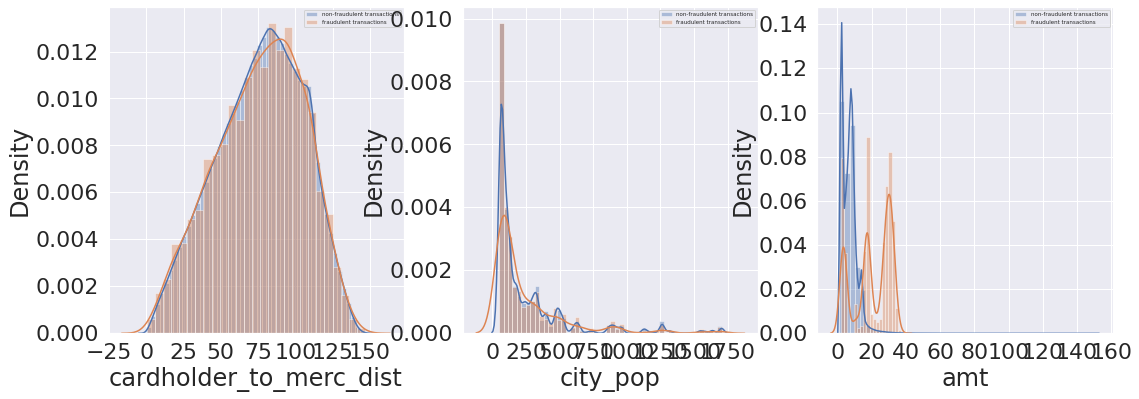

In [ ]:
fig, ax = plt.subplots(1, 3,figsize = (18,6))
sns.set(font_scale=0.5) 
mask = df['is_fraud']==1

sns.distplot(df[~mask]['cardholder_to_merc_dist'], label = 'non-fraudulent transactions',kde = True , ax = ax[0])
sns.distplot(df[mask]['cardholder_to_merc_dist'], label = 'fraudulent transactions',kde = True , ax = ax[0])

sns.distplot(df[~mask]['city_pop']**0.5,ax = ax[1] , label = 'non-fraudulent transactions' )
sns.distplot(df[mask]['city_pop']**0.5, ax = ax[1],  label = 'fraudulent transactions')


sns.distplot(df[~mask]['amt']**0.5, label = 'non-fraudulent transactions',kde = True , ax = ax[2])
sns.distplot(df[mask]['amt']**0.5, label = 'fraudulent transactions',kde = True , ax = ax[2])

ax[0].legend()
ax[1].legend()
ax[2].legend()

1. On a high level distribution of city population and distance from card holderto merc seems similar for both fraudulent and non-fraudulent transactions.

2. This doesn't seem to be the case for fraudulent transactions. Fraudulent transactions amount distribution seems to differe from ordinary transactions.

#Feature 6 : 

In [ ]:
def previous_transaction(df_):
  cc_list = list(df_['cc_num'].unique())
  df_temp =pd.DataFrame({})

  for cc_num in cc_list:
    mask = df_['cc_num'] == cc_num
    temp = df_[mask].copy()
    temp['trans_shift'] = None
    temp.loc[:,'trans_shift'] = temp['trans_date_time'].diff()
    temp['amt_shift'] = None
    temp.loc[:,'amt_shift'] = temp['amt'].diff()

    temp['merch_lat_previous'] = temp['merch_lat'].shift(periods = 1)
    temp['merch_long_previous'] = temp['merch_long'].shift(periods = 1)

    temp['distance_from_last'] = haversine(temp.merch_lat.values,
                                           temp.merch_long.values,
                                           temp.merch_lat_previous.values,
                                           temp.merch_long_previous.values)

    df_temp = pd.concat([df_temp,temp])
  return df_temp

### Feature 7: Travel speed.

In [ ]:
def travel_speed(df_):
  df_.loc[df_['trans_shift'].isna(),'trans_shift'] = timedelta(seconds= 0) #impute missing data in the trans_shift with 0 seconds, as there are only missing data in this column beecause 
                                                                       # there are no prior data, as it computes the time between previous and current transsaction time.
  df_['trans_shift'] = df_['trans_shift'].dt.seconds           
  df_['travel_speed'] = df_['distance_from_last']/df_['trans_shift']
  return df_

In [ ]:
df= num_trans_last_xdays(df,30)
df_test = num_trans_last_xdays(df_test,30)

In [ ]:
df = previous_transaction(df.sort_values(by = 'trans_date_time'))
df_test = previous_transaction(df_test.sort_values(by = 'trans_date_time'))

KeyboardInterrupt: ignored

In [ ]:
df = travel_speed(df)
df_test = travel_speed(df_test)

9months vs last 3 months

In [ ]:
df['amt_shift'].fillna(0,inplace = True)
df_test['amt_shift'].fillna(0,inplace = True)

In [ ]:
#df_[mask]['amt_shift'].sort_values(ascending = False)

fig, ax = plt.subplots(1, 2,figsize = (16,9))
mask = df['is_fraud'] == 1

sns.distplot(df[~mask]['trans_shift']**0.5, label = 'non-fraudulent transactions',kde = True , ax = ax[0])
sns.distplot(df[mask]['trans_shift']**0.5, label = 'fraudulent transactions',kde = True , ax = ax[0])
ax[0].set_title('time difference from previous transaction')

sns.distplot(df[~mask]['amt_shift']**0.5, label = 'non-fraudulent transactions',kde = True , ax = ax[1])
sns.distplot(df[mask]['amt_shift']**0.5, label = 'fraudulent transactions',kde = True , ax = ax[1])
ax[1].set_title('amount difference from previous transaction')

1. The distribution difference suggests that the fraudulent activities tend to break away from usual activities - transacted amount and time between transactions is different from the usual.

In [ ]:
mask = df['is_fraud'] == 1
cc_flist = list(df[mask]['cc_num'].unique())

In [ ]:
mask = df['cc_num'] == cc_flist[5]
df[mask&df['is_fraud']==1][['is_fraud','trans_shift','amt']]

In [ ]:
df.to_csv('train_engineered.csv')
df_test.to_csv('test_engineered.csv')

In [ ]:
from google.colab import files
files.download("train_engineered.csv")
files.download("test_engineered.csv")

In [ ]:
files.download('test_engineered.csv')